In [1]:
# Import necessary libraries
import pandas as pd

# Define your file path
file_path = r"C:\Users\tanishq\Desktop\cap3\FAOSTAT_data.xlsx"

# Load the data from the correct sheet
data = pd.read_excel(file_path, sheet_name='FAOSTAT_data_en_12-29-2024')

# Check the first few rows to confirm data is loaded
data.head()


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2019,2019,ha,29203.0,A,Official figure,NaN
1,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2019,2019,kg/ha,1308.3,A,Official figure,NaN
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1371,"Almonds, in shell",2019,2019,t,38205.0,A,Official figure,NaN
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2020,2020,ha,22134.0,A,Official figure,NaN
4,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2020,2020,kg/ha,1775.9,A,Official figure,NaN


In [2]:
# Select only the relevant columns
data_filtered = data[['Area', 'Item', 'Year', 'Element', 'Value']]

# Preview the filtered data
data_filtered.head()


,Area,Item,Year,Element,Value
0,Afghanistan,"Almonds, in shell",2019,Area harvested,29203.0
1,Afghanistan,"Almonds, in shell",2019,Yield,1308.3
2,Afghanistan,"Almonds, in shell",2019,Production,38205.0
3,Afghanistan,"Almonds, in shell",2020,Area harvested,22134.0
4,Afghanistan,"Almonds, in shell",2020,Yield,1775.9


In [3]:
# Pivot Element column into separate columns for Area harvested, Yield, Production
pivoted_data = data_filtered.pivot_table(
    index=['Area', 'Item', 'Year'],
    columns='Element',
    values='Value'
).reset_index()

# Rename columns for easier access if needed (optional)
pivoted_data.columns.name = None  # Remove the hierarchy name from columns
pivoted_data.head()


,Area,Item,Year,Area harvested,Laying,Milk Animals,Producing Animals/Slaughtered,Production,Stocks,Yield,Yield/Carcass Weight
0,Afghanistan,"Almonds, in shell",2019,29203.0,NaN,NaN,NaN,38205.0,NaN,1308.3,NaN
1,Afghanistan,"Almonds, in shell",2020,22134.0,NaN,NaN,NaN,39307.0,NaN,1775.9,NaN
2,Afghanistan,"Almonds, in shell",2021,36862.0,NaN,NaN,NaN,64256.0,NaN,1743.2,NaN
3,Afghanistan,"Almonds, in shell",2022,36462.0,NaN,NaN,NaN,63515.0,NaN,1742.0,NaN
4,Afghanistan,"Almonds, in shell",2023,37000.0,NaN,NaN,NaN,67000.0,NaN,1810.8,NaN


In [4]:
# Check for missing values
pivoted_data.isnull().sum()


Area                                 0
Item                                 0
Year                                 0
Area harvested                   44521
Laying                           91359
Milk Animals                     90314
Producing Animals/Slaughtered    74859
Production                       10478
Stocks                           83820
Yield                            41849
Yield/Carcass Weight             86115
dtype: int64

In [5]:
# Drop unnecessary columns (extra livestock-related columns)
columns_to_drop = [
    'Laying', 
    'Milk Animals', 
    'Producing Animals/Slaughtered', 
    'Stocks', 
    'Yield/Carcass Weight'
]

# Only drop if these columns exist (to avoid errors)
pivoted_data = pivoted_data.drop(columns=[col for col in columns_to_drop if col in pivoted_data.columns])

# Check the cleaned data structure
pivoted_data.head()


,Area,Item,Year,Area harvested,Production,Yield
0,Afghanistan,"Almonds, in shell",2019,29203.0,38205.0,1308.3
1,Afghanistan,"Almonds, in shell",2020,22134.0,39307.0,1775.9
2,Afghanistan,"Almonds, in shell",2021,36862.0,64256.0,1743.2
3,Afghanistan,"Almonds, in shell",2022,36462.0,63515.0,1742.0
4,Afghanistan,"Almonds, in shell",2023,37000.0,67000.0,1810.8


In [6]:
# Check for missing values
pivoted_data.isnull().sum()


Area                  0
Item                  0
Year                  0
Area harvested    44521
Production        10478
Yield             41849
dtype: int64

In [8]:
# Step 1: Check how many missing values each crop still has
missing_summary = pivoted_data.groupby('Item')[['Area harvested', 'Yield']].apply(lambda x: x.isnull().sum())
missing_summary


,Area harvested,Yield
Item,,
"Abaca, manila hemp, raw",0,0
"Agave fibres, raw, n.e.c.",0,0
"Almonds, in shell",0,0
"Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw",0,0
Apples,0,0
...,...,...
"Whole milk, evaporated",248,248
Wine,299,299
Yams,0,0


In [10]:
# Step 1: Check total non-missing counts for each crop
non_missing_counts = pivoted_data.groupby('Item')[['Area harvested', 'Yield']].count()

# Step 2: Combine missing summary and non-missing counts into one DataFrame
missing_summary = pivoted_data.groupby('Item')[['Area harvested', 'Yield']].apply(lambda x: x.isnull().sum())
missing_summary['Area harvested non-missing'] = non_missing_counts['Area harvested']
missing_summary['Yield non-missing'] = non_missing_counts['Yield']

# Step 3: Identify crops where non-missing count is 0 for Area harvested or Yield
crops_to_drop = missing_summary[
    (missing_summary['Area harvested non-missing'] == 0) |
    (missing_summary['Yield non-missing'] == 0)
].index.tolist()

# Check crops to be dropped
print(crops_to_drop)


['Asses', 'Beer of barley, malted', 'Bees', 'Beeswax', 'Brazil nuts, in shell', 'Buffalo', 'Buffalo fat, unrendered', 'Butter and ghee of sheep milk', 'Butter of buffalo milk', 'Butter of cow milk', 'Buttermilk, dry', 'Camels', 'Cattle', 'Cattle fat, unrendered', 'Cheese from milk of buffalo, fresh or processed', 'Cheese from milk of goats, fresh or processed', 'Cheese from milk of sheep, fresh or processed', 'Cheese from skimmed cow milk', 'Cheese from whole cow milk', 'Chickens', 'Coconut oil', 'Coir, raw', 'Cotton lint, ginned', 'Cotton seed', 'Cottonseed oil', 'Cream, fresh', 'Ducks', 'Edible offal of buffalo, fresh, chilled or frozen', 'Edible offal of cattle, fresh, chilled or frozen', 'Edible offal of goat, fresh, chilled or frozen', 'Edible offal of pigs, fresh, chilled or frozen', 'Edible offal of sheep, fresh, chilled or frozen', 'Edible offals of camels and other camelids, fresh, chilled or frozen', 'Edible offals of horses and other equines,  fresh, chilled or frozen', 'Egg

In [11]:
# Drop the identified crops/items with fully missing data
pivoted_data = pivoted_data[~pivoted_data['Item'].isin(crops_to_drop)]

# Confirm the shape after dropping
pivoted_data.shape

# Optional: Check missing values again before imputation
pivoted_data.isnull().sum()

Area                0
Item                0
Year                0
Area harvested      0
Production        182
Yield               0
dtype: int64

In [13]:
# 🟢 Explanation:
# After analyzing missing values, we observed that some crop groups (Items) 
# had completely missing data for either 'Area harvested' or 'Yield'.
# 
# According to best practices (and as advised by my mentor Aravinth sir), 
# if an entire group has missing values for a feature, it is not possible 
# to impute those values using median/mean (because there is no data to calculate from).
#
# Blindly imputing such groups would introduce bias or wrong estimations, 
# and directly dropping rows without checking would lose valuable data unnecessarily.
#
# Therefore, we safely identified ONLY those crops (Items) where:
# - 'Area harvested' was missing for all rows within that crop group, OR
# - 'Yield' was missing for all rows within that crop group.
#
# These crops are mostly livestock-related or non-crop products, 
# so dropping them is also logically aligned with our project's focus on crop production.
#
# ✅ This approach follows systematic data cleaning:
#    - Keeps important crop data safe
#    - Removes only those groups where imputation is not possible
#    - Matches the EDA guidelines provided by Aravinth sir.

# Drop rows where Production (target) is missing
final_cleaned_data = pivoted_data[pivoted_data['Production'].notnull()]

# Check the shape of your final cleaned data
final_cleaned_data.shape

# Confirm no missing values now
final_cleaned_data.isnull().sum()


Area              0
Item              0
Year              0
Area harvested    0
Production        0
Yield             0
dtype: int64

In [14]:
# 🟢 Explanation:
# After handling missing values for 'Area harvested' and 'Yield', 
# we found that there are still 182 rows where the 'Production' value is missing.
#
# 'Production' is our target variable (the value we are trying to predict 
# using machine learning regression models).
#
# ✅ Very Important Rule:
# In supervised learning, we cannot fill (impute) missing values in the target/output column 
# because that would mean "making up" the answers that the model is supposed to learn from.
#
# Imputing the target variable leads to:
# - Data leakage (the model might learn from incorrect values)
# - Biased or wrong predictions
# - Invalid evaluation results
#
# 🟢 Therefore, the correct approach is:
# - Safely drop rows where 'Production' is missing.
# - This ensures that the model trains only on valid, real data.
#
# ⚡ This step aligns with standard data science best practices 
# and maintains the integrity of the prediction task.


In [15]:
final_cleaned_data.head(20)

,Area,Item,Year,Area harvested,Production,Yield
0,Afghanistan,"Almonds, in shell",2019,29203.0,38205.00,1308.3
1,Afghanistan,"Almonds, in shell",2020,22134.0,39307.00,1775.9
2,Afghanistan,"Almonds, in shell",2021,36862.0,64256.00,1743.2
3,Afghanistan,"Almonds, in shell",2022,36462.0,63515.00,1742.0
4,Afghanistan,"Almonds, in shell",2023,37000.0,67000.00,1810.8
5,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2019,25293.0,17807.76,704.1
6,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2020,25558.0,17965.90,703.0
7,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2021,25357.0,17876.49,705.0
8,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2022,25403.0,17883.38,704.0
9,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",2023,25439.0,17908.59,704.0


In [17]:
# Save the final cleaned data to CSV
final_cleaned_data.to_csv('final_cleaned_crop_data.csv', index=False)

print("✅ Cleaned data saved as 'final_cleaned_crop_data.csv'")


✅ Cleaned data saved as 'final_cleaned_crop_data.csv'


In [18]:
final_cleaned_data.isnull().sum()


Area              0
Item              0
Year              0
Area harvested    0
Production        0
Yield             0
dtype: int64

In [19]:
# ✅ Step 1: Check shape (rows, columns)
print("Shape of the data:", final_cleaned_data.shape)

# ✅ Step 2: Data types and structure
print("\nData types and first few rows:")
print(final_cleaned_data.dtypes)
final_cleaned_data.head()

# ✅ Step 3: Check for any missing values (should be zero now)
print("\nMissing values in each column:")
print(final_cleaned_data.isnull().sum())

# ✅ Step 4: Memory usage and data info
print("\nDataset Info:")
final_cleaned_data.info()


Shape of the data: (47934, 6)

Data types and first few rows:
Area               object
Item               object
Year                int64
Area harvested    float64
Production        float64
Yield             float64
dtype: object

Missing values in each column:
Area              0
Item              0
Year              0
Area harvested    0
Production        0
Yield             0
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 47934 entries, 0 to 92421
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area            47934 non-null  object 
 1   Item            47934 non-null  object 
 2   Year            47934 non-null  int64  
 3   Area harvested  47934 non-null  float64
 4   Production      47934 non-null  float64
 5   Yield           47934 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.6+ MB


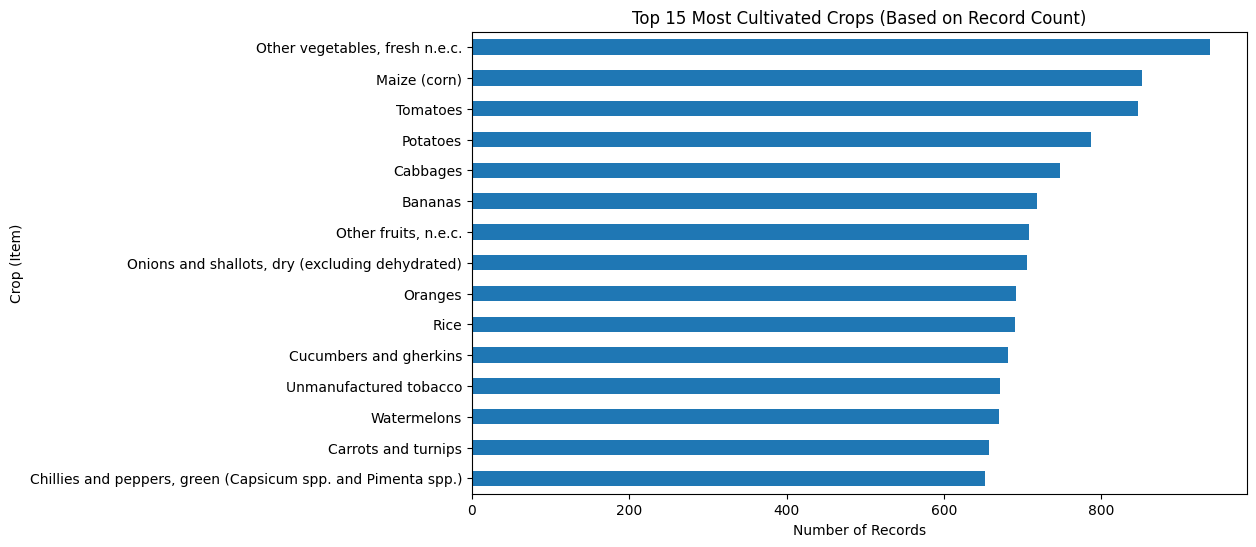


Least cultivated crops (bottom 10):
Item
Ramie, raw or retted        22
Peppermint, spearmint       20
Poppy seed                  20
Cashewapple                 20
Quinoa                      19
Mat� leaves                 15
Other sugar crops n.e.c.    15
Tallowtree seeds            10
Kapok fruit                 10
Jojoba seeds                 5
Name: count, dtype: int64


In [20]:
import matplotlib.pyplot as plt

# Count number of records per crop (Item)
crop_counts = final_cleaned_data['Item'].value_counts()

# Plot Top 15 Most Cultivated Crops
plt.figure(figsize=(10, 6))
crop_counts.head(15).plot(kind='barh')
plt.xlabel('Number of Records')
plt.ylabel('Crop (Item)')
plt.title('Top 15 Most Cultivated Crops (Based on Record Count)')
plt.gca().invert_yaxis()  # Most on top
plt.show()

# Optional: Check Least Cultivated Crops
print("\nLeast cultivated crops (bottom 10):")
print(crop_counts.tail(10))


In [22]:
# Count unique crops
total_crops = final_cleaned_data['Item'].nunique()
print("Total number of unique crops (Item):", total_crops)


Total number of unique crops (Item): 157


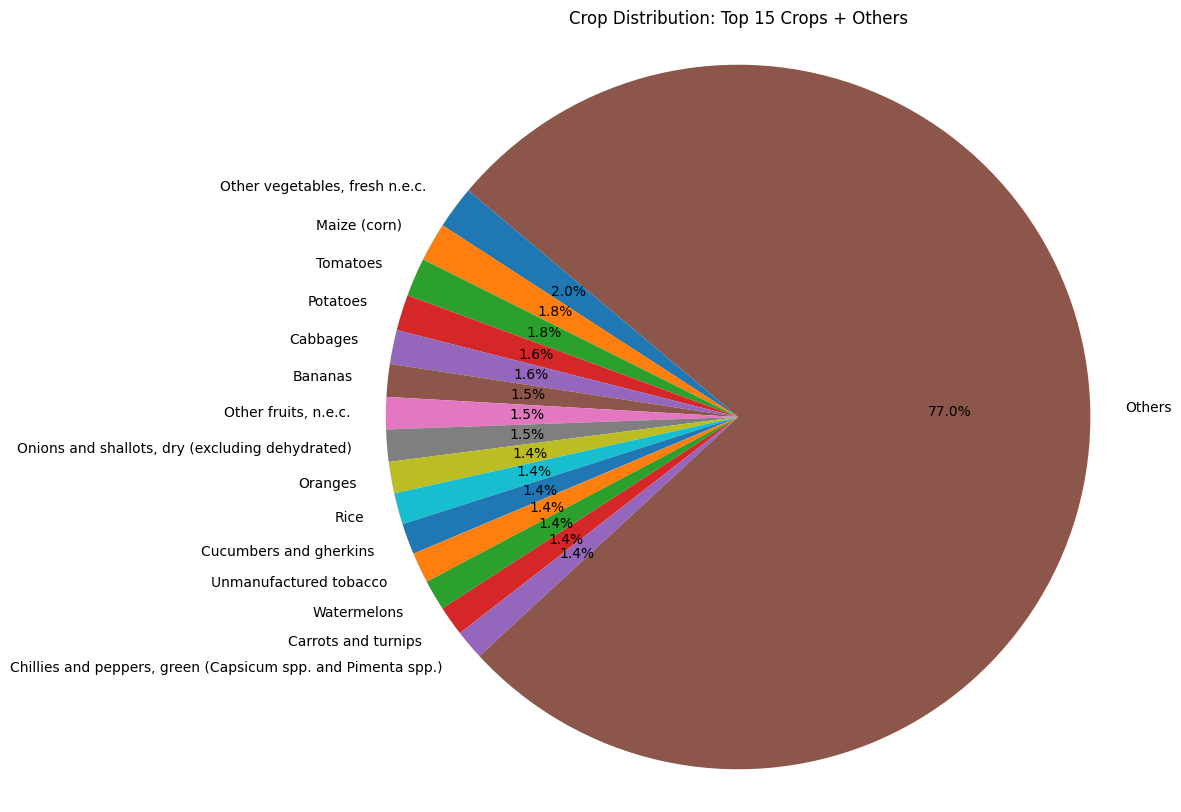

In [23]:
import matplotlib.pyplot as plt

# Count records per crop
crop_counts = final_cleaned_data['Item'].value_counts()

# Separate top 15 and group the rest as "Others"
top_n = 15
top_crops = crop_counts[:top_n]
others_sum = crop_counts[top_n:].sum()

# Combine top crops with "Others"
crop_labels = list(top_crops.index) + ['Others']
crop_values = list(top_crops.values) + [others_sum]

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(crop_values, labels=crop_labels, autopct='%1.1f%%', startangle=140)
plt.title('Crop Distribution: Top 15 Crops + Others')
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle
plt.show()


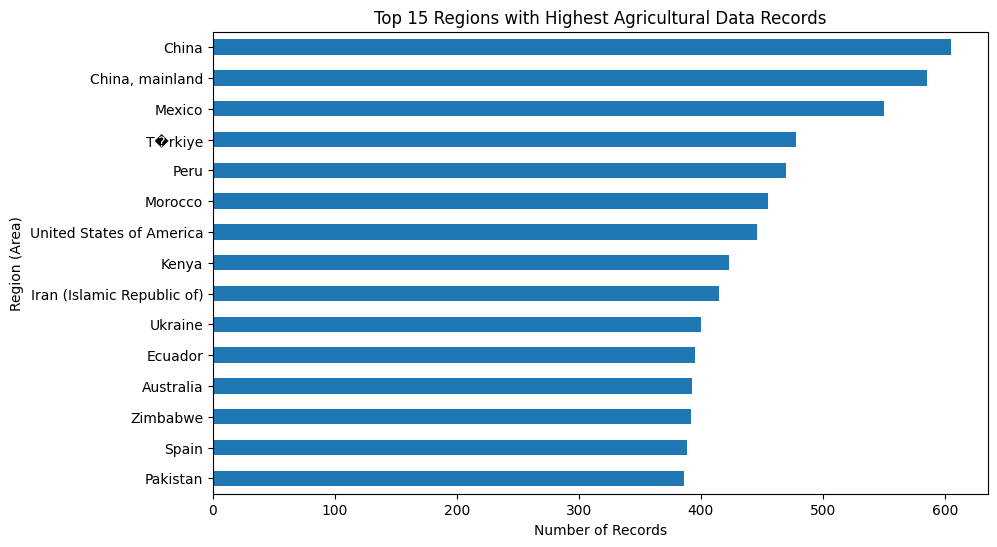


Least active regions (bottom 10):
Area
Equatorial Guinea    50
Singapore            50
Niue                 50
Iceland              35
Kiribati             30
Tuvalu               25
Tokelau              20
China, Macao SAR      5
Faroe Islands         5
Marshall Islands      5
Name: count, dtype: int64


In [24]:
import matplotlib.pyplot as plt

# Count the number of records for each region (Area)
region_counts = final_cleaned_data['Area'].value_counts()

# Plot Top 15 Regions (Areas) by number of records
plt.figure(figsize=(10, 6))
region_counts.head(15).plot(kind='barh')
plt.xlabel('Number of Records')
plt.ylabel('Region (Area)')
plt.title('Top 15 Regions with Highest Agricultural Data Records')
plt.gca().invert_yaxis()  # Most on top
plt.show()

# Optional: Check Least Active Regions
print("\nLeast active regions (bottom 10):")
print(region_counts.tail(10))


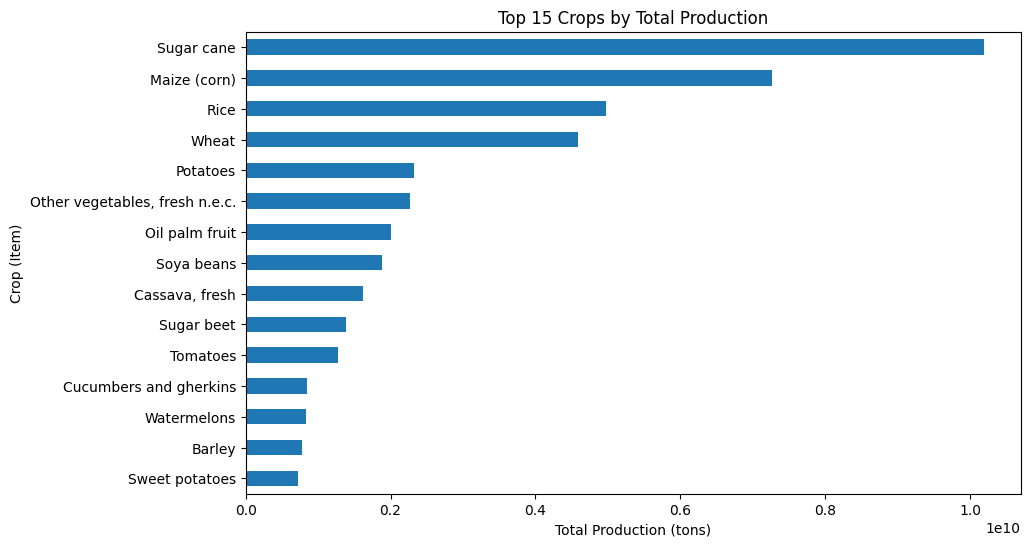

In [25]:
import matplotlib.pyplot as plt

# Group by Item and sum the Production
crop_production = final_cleaned_data.groupby('Item')['Production'].sum().sort_values(ascending=False)

# Plot Top 15 crops by total production
plt.figure(figsize=(10, 6))
crop_production.head(15).plot(kind='barh')
plt.xlabel('Total Production (tons)')
plt.ylabel('Crop (Item)')
plt.title('Top 15 Crops by Total Production')
plt.gca().invert_yaxis()
plt.show()


In [27]:
# Group by Area and Item, sum the Production
region_crop_prod = final_cleaned_data.groupby(['Area', 'Item'])['Production'].sum().reset_index()

# For each region, get the crop with the maximum production
top_crop_per_region = region_crop_prod.loc[region_crop_prod.groupby('Area')['Production'].idxmax()]

# Check the result
top_crop_per_region.head(50)  # Show first 15 regions' top crops


,Area,Item,Production
37,Afghanistan,Wheat,2.219555e+07
61,Albania,Maize (corn),2.012882e+06
140,Algeria,Potatoes,2.302889e+07
161,Angola,"Cassava, fresh",5.024778e+07
206,Antigua and Barbuda,"Other tropical fruits, n.e.c.",3.184726e+04
247,Argentina,Maize (corn),2.762289e+08
323,Armenia,Potatoes,1.921765e+06
405,Australia,Sugar cane,1.550910e+08
471,Austria,Sugar beet,1.245951e+07
540,Azerbaijan,Wheat,9.253243e+06


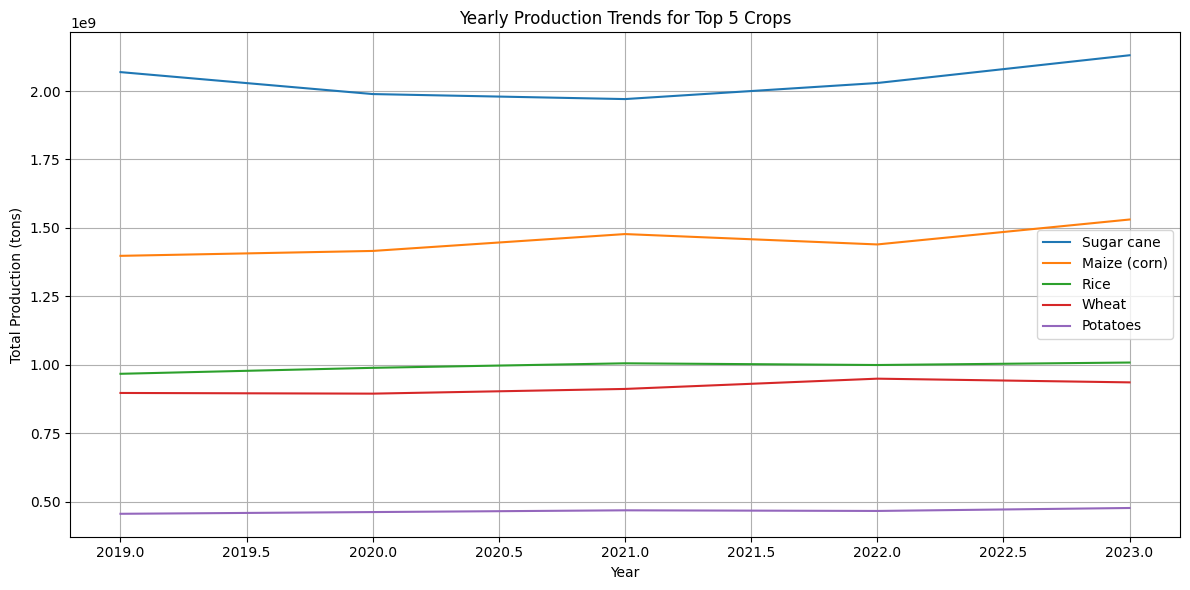

In [34]:
import matplotlib.pyplot as plt

# Step 1: Identify top 5 crops by total production
top5_crops = final_cleaned_data.groupby('Item')['Production'].sum().sort_values(ascending=False).head(5).index

# Step 2: Filter data for only these top 5 crops
top5_data = final_cleaned_data[final_cleaned_data['Item'].isin(top5_crops)]

# Step 3: Plot production trend for top 5 crops
plt.figure(figsize=(12, 6))
for crop in top5_crops:
    yearly_production = top5_data[top5_data['Item'] == crop].groupby('Year')['Production'].sum()
    plt.plot(yearly_production.index, yearly_production.values, label=crop)

plt.title('Yearly Production Trends for Top 5 Crops')
plt.xlabel('Year')
plt.ylabel('Total Production (tons)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


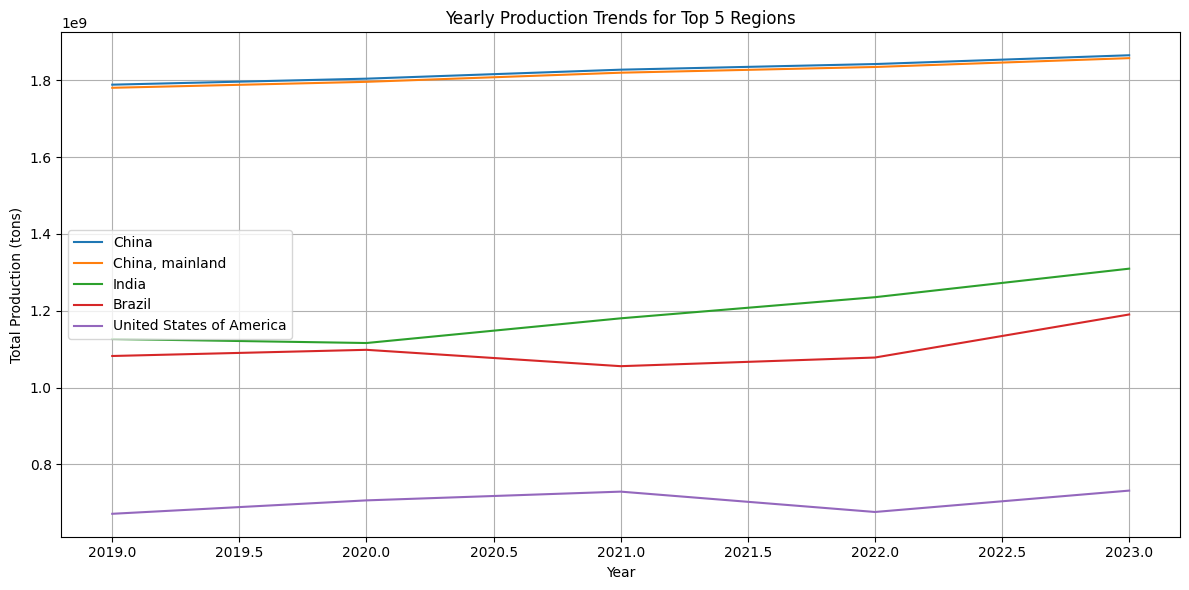

In [35]:
import matplotlib.pyplot as plt

# Step 1: Identify top 5 regions by total production
top5_regions = final_cleaned_data.groupby('Area')['Production'].sum().sort_values(ascending=False).head(5).index

# Step 2: Filter data for only these top 5 regions
top5_region_data = final_cleaned_data[final_cleaned_data['Area'].isin(top5_regions)]

# Step 3: Plot production trend for top 5 regions
plt.figure(figsize=(12, 6))
for region in top5_regions:
    yearly_production = top5_region_data[top5_region_data['Area'] == region].groupby('Year')['Production'].sum()
    plt.plot(yearly_production.index, yearly_production.values, label=region)

plt.title('Yearly Production Trends for Top 5 Regions')
plt.xlabel('Year')
plt.ylabel('Total Production (tons)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


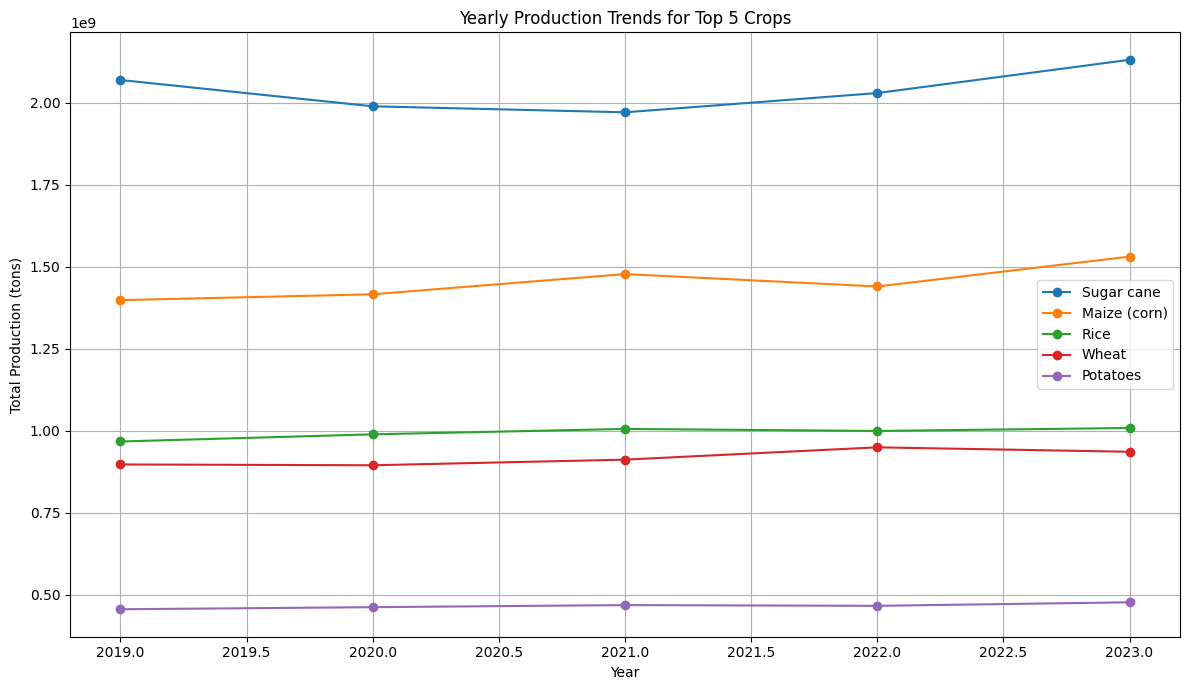

In [37]:
import matplotlib.pyplot as plt

# First, identify top 5 crops by total production
top_5_crops = final_cleaned_data.groupby('Item')['Production'].sum().sort_values(ascending=False).head(5).index

# Filter data for these top crops
top_crops_data = final_cleaned_data[final_cleaned_data['Item'].isin(top_5_crops)]

# Group by Item and Year, then sum production
crop_trends = top_crops_data.groupby(['Item', 'Year'])['Production'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 7))
for crop in top_5_crops:
    crop_data = crop_trends[crop_trends['Item'] == crop]
    plt.plot(crop_data['Year'], crop_data['Production'], marker='o', label=crop)

plt.title('Yearly Production Trends for Top 5 Crops')
plt.xlabel('Year')
plt.ylabel('Total Production (tons)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
import pandas as pd

# Load the cleaned dataset
final_cleaned_data = pd.read_csv('final_cleaned_crop_data.csv')

# Check if loaded correctly
print("✅ Data loaded successfully!")
print(final_cleaned_data.shape)
final_cleaned_data.head()


✅ Data loaded successfully!
(47934, 6)


,Area,Item,Year,Area harvested,Production,Yield
0,Afghanistan,"Almonds, in shell",2019,29203.0,38205.0,1308.3
1,Afghanistan,"Almonds, in shell",2020,22134.0,39307.0,1775.9
2,Afghanistan,"Almonds, in shell",2021,36862.0,64256.0,1743.2
3,Afghanistan,"Almonds, in shell",2022,36462.0,63515.0,1742.0
4,Afghanistan,"Almonds, in shell",2023,37000.0,67000.0,1810.8


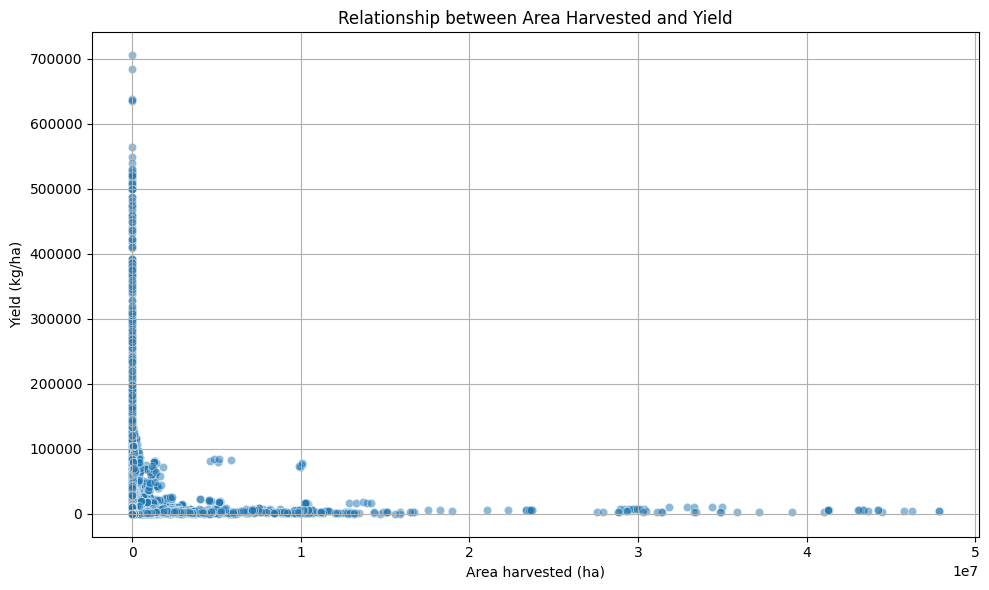

Correlation between Area harvested and Yield: -0.0254


In [2]:
#environmental analysiss.
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplot: Area harvested vs Yield
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_cleaned_data, x='Area harvested', y='Yield', alpha=0.5)
plt.title('Relationship between Area Harvested and Yield')
plt.xlabel('Area harvested (ha)')
plt.ylabel('Yield (kg/ha)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation calculation
correlation = final_cleaned_data['Area harvested'].corr(final_cleaned_data['Yield'])
print(f"Correlation between Area harvested and Yield: {correlation:.4f}")


In [3]:
#The relationship between Area harvested and Yield was analyzed using scatterplots and correlation analysis. 
#The correlation coefficient (-0.0254) suggests there is no strong linear association between land usage and productivity. 
#This indicates that factors other than just the area harvested may play a more significant role in determining crop yield

                Area harvested     Yield  Production
Area harvested        1.000000 -0.025409    0.641110
Yield                -0.025409  1.000000    0.053538
Production            0.641110  0.053538    1.000000


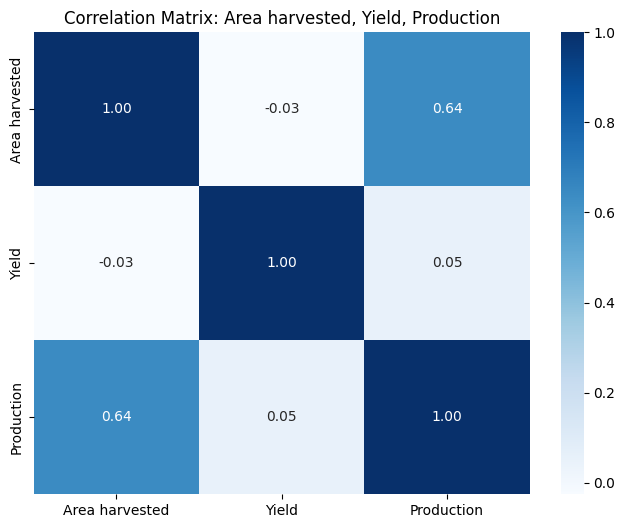

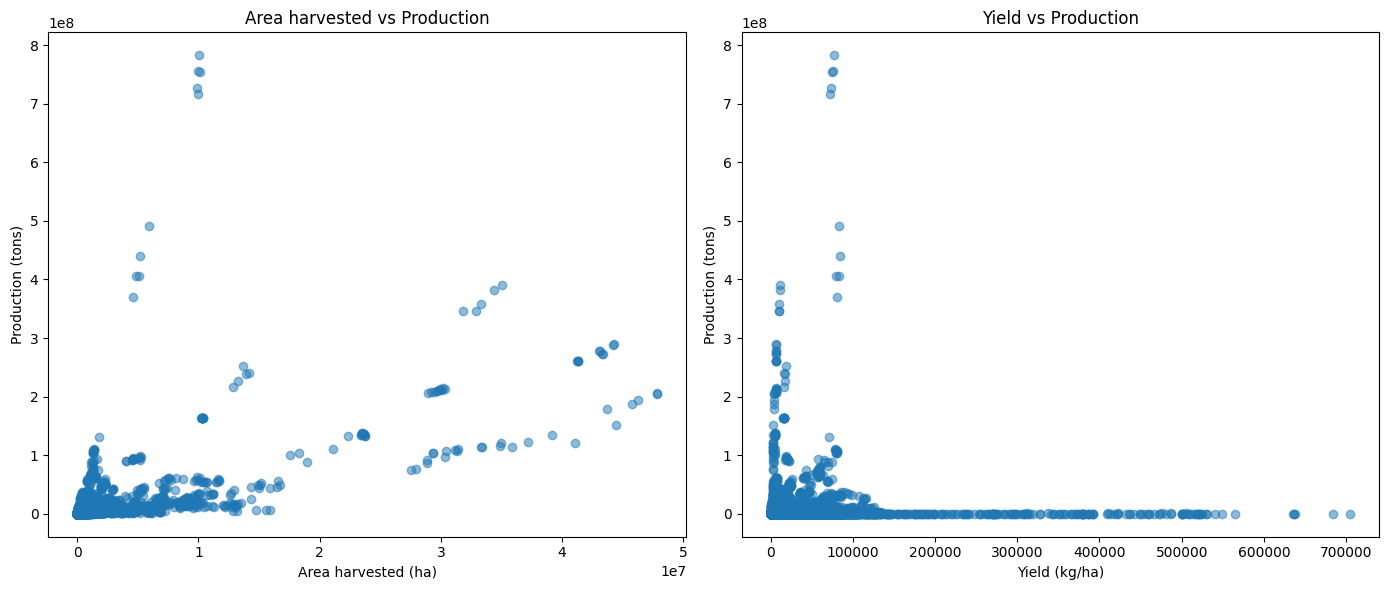

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix using your dataframe
correlation_matrix = final_cleaned_data[['Area harvested', 'Yield', 'Production']].corr()
print(correlation_matrix)

# Heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix: Area harvested, Yield, Production')
plt.show()

# Scatterplots for visual check
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(final_cleaned_data['Area harvested'], final_cleaned_data['Production'], alpha=0.5)
plt.xlabel('Area harvested (ha)')
plt.ylabel('Production (tons)')
plt.title('Area harvested vs Production')

plt.subplot(1, 2, 2)
plt.scatter(final_cleaned_data['Yield'], final_cleaned_data['Production'], alpha=0.5)
plt.xlabel('Yield (kg/ha)')
plt.ylabel('Production (tons)')
plt.title('Yield vs Production')

plt.tight_layout()
plt.show()



In [6]:
#The correlation analysis between Area harvested, Yield, and Production provides insights into the relationship between land usage and crop productivity.

#- **Production is highly influenced by Area harvested (correlation: 0.64)**, indicating that the total land used significantly affects the total output.
#- **Yield has a very low correlation with Production (0.05)**, suggesting that productivity per hectare varies independently of total output.
#- **Area harvested and Yield show almost no relationship (-0.03)**, confirming that expanding land area does not guarantee better yield per hectare.

#These insights highlight that land expansion alone is not enough for productivity improvement; 
#factors like crop quality, farming methods, and environmental conditions likely play a critical role.


In [8]:
#comparative analysis
# Calculate average Yield for each crop
avg_yield_per_crop = final_cleaned_data.groupby('Item')['Yield'].mean().sort_values(ascending=False)

# Display top 10 high-yield crops
print("Top 10 High-Yield Crops:")
print(avg_yield_per_crop.head(10))

# Display bottom 10 low-yield crops
print("\nBottom 10 Low-Yield Crops:")
print(avg_yield_per_crop.tail(10))



Top 10 High-Yield Crops:
Item
Cucumbers and gherkins                                          59693.992962
Tomatoes                                                        59496.026741
Sugar cane                                                      58178.661795
Sugar beet                                                      50054.597187
Eggplants (aubergines)                                          34573.188623
Watermelons                                                     29869.912836
Chillies and peppers, green (Capsicum spp. and Pimenta spp.)    29363.978681
Carrots and turnips                                             28408.210654
Papayas                                                         27246.432402
Cabbages                                                        26680.832530
Name: Yield, dtype: float64

Bottom 10 Low-Yield Crops:
Item
Coffee, green                786.090886
Fonio                        784.007273
Agave fibres, raw, n.e.c.    741.750000
Bambara beans, dry 

In [9]:
### Result:
#- Crops like **Cucumbers and gherkins, Tomatoes, Sugar cane, and Sugar beet** were identified as the highest-yielding crops.
#- Crops such as **Vanilla, Pyrethrum, Kola nuts, and Cocoa beans** were identified as the lowest-yielding crops.


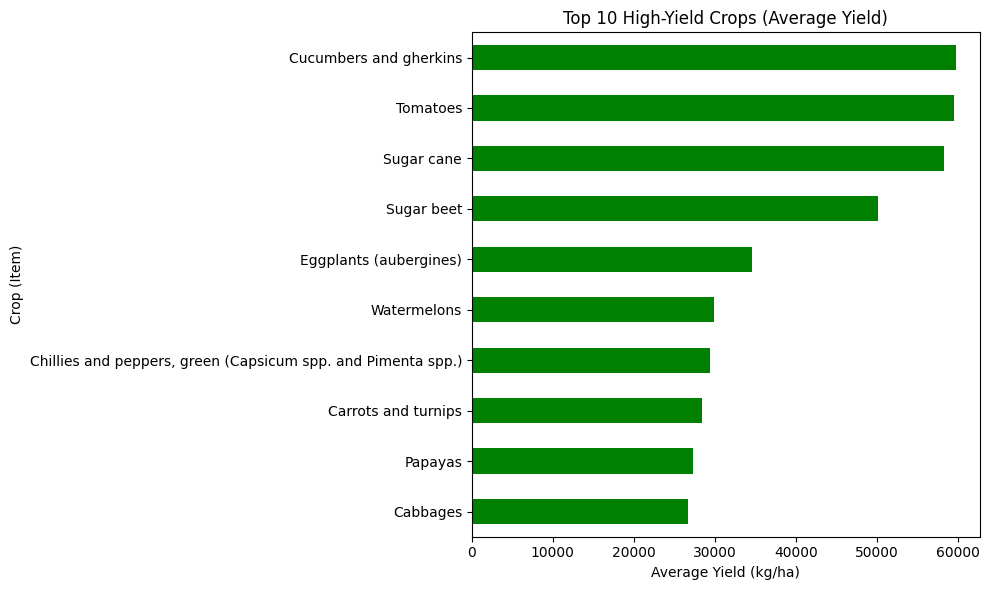

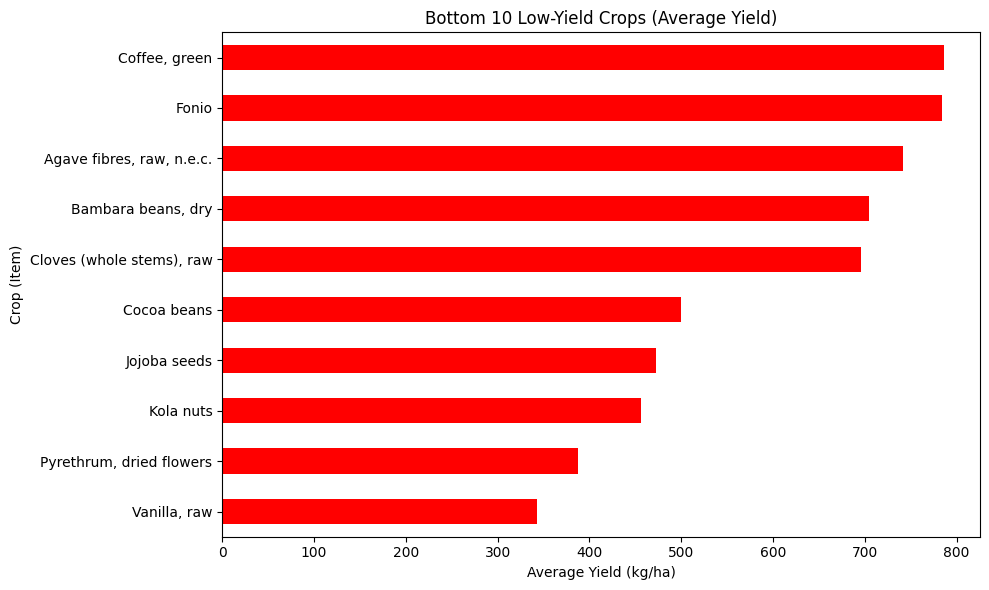

In [10]:
import matplotlib.pyplot as plt

# Plot: Top 10 High-Yield Crops
plt.figure(figsize=(10, 6))
avg_yield_per_crop.head(10).plot(kind='barh', color='green')
plt.title('Top 10 High-Yield Crops (Average Yield)')
plt.xlabel('Average Yield (kg/ha)')
plt.ylabel('Crop (Item)')
plt.gca().invert_yaxis()  # Highest yield at the top
plt.tight_layout()
plt.show()

# Plot: Bottom 10 Low-Yield Crops
plt.figure(figsize=(10, 6))
avg_yield_per_crop.tail(10).plot(kind='barh', color='red')
plt.title('Bottom 10 Low-Yield Crops (Average Yield)')
plt.xlabel('Average Yield (kg/ha)')
plt.ylabel('Crop (Item)')
plt.gca().invert_yaxis()  # Lowest yield at the top
plt.tight_layout()
plt.show()


Top 10 Highly Productive Regions:
Area
China                       9.127343e+09
China, mainland             9.088067e+09
India                       5.968086e+09
Brazil                      5.505432e+09
United States of America    3.516034e+09
Indonesia                   2.116899e+09
Russian Federation          1.229384e+09
Nigeria                     1.082556e+09
Thailand                    9.953560e+08
Argentina                   8.273916e+08
Name: Production, dtype: float64


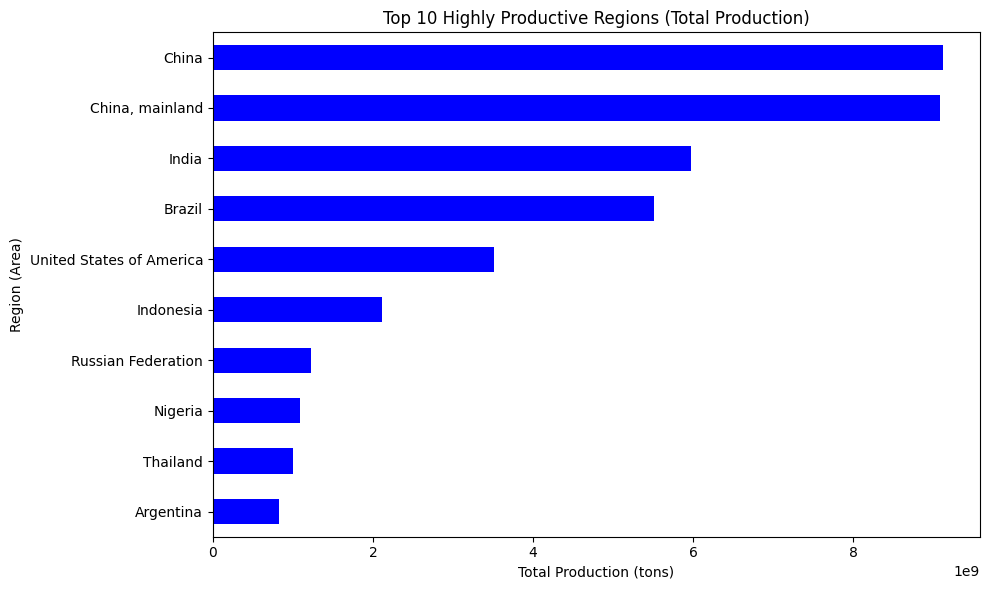

In [11]:
# Calculate total production for each region
total_production_per_region = final_cleaned_data.groupby('Area')['Production'].sum().sort_values(ascending=False)

# Display the top 10 highly productive regions
print("Top 10 Highly Productive Regions:")
print(total_production_per_region.head(10))

# Bar plot for top 10 regions
plt.figure(figsize=(10, 6))
total_production_per_region.head(10).plot(kind='barh', color='blue')
plt.title('Top 10 Highly Productive Regions (Total Production)')
plt.xlabel('Total Production (tons)')
plt.ylabel('Region (Area)')
plt.gca().invert_yaxis()  # Most productive region on top
plt.tight_layout()
plt.show()


In [2]:
# Add a new column: Productivity Ratio
final_cleaned_data['Productivity Ratio'] = final_cleaned_data['Production'] / final_cleaned_data['Area harvested']

# Check the first few rows
final_cleaned_data[['Item', 'Area', 'Year', 'Area harvested', 'Production', 'Yield', 'Productivity Ratio']].head()


,Item,Area,Year,Area harvested,Production,Yield,Productivity Ratio
0,"Almonds, in shell",Afghanistan,2019,29203.0,38205.0,1308.3,1.308256
1,"Almonds, in shell",Afghanistan,2020,22134.0,39307.0,1775.9,1.775865
2,"Almonds, in shell",Afghanistan,2021,36862.0,64256.0,1743.2,1.743150
3,"Almonds, in shell",Afghanistan,2022,36462.0,63515.0,1742.0,1.741951
4,"Almonds, in shell",Afghanistan,2023,37000.0,67000.0,1810.8,1.810811


In [3]:
# Convert Production from tons to kilograms
final_cleaned_data['Productivity Ratio'] = (final_cleaned_data['Production'] * 1000) / final_cleaned_data['Area harvested']

# Check again
final_cleaned_data[['Item', 'Area', 'Year', 'Area harvested', 'Production', 'Yield', 'Productivity Ratio']].head()


,Item,Area,Year,Area harvested,Production,Yield,Productivity Ratio
0,"Almonds, in shell",Afghanistan,2019,29203.0,38205.0,1308.3,1308.256001
1,"Almonds, in shell",Afghanistan,2020,22134.0,39307.0,1775.9,1775.865185
2,"Almonds, in shell",Afghanistan,2021,36862.0,64256.0,1743.2,1743.150128
3,"Almonds, in shell",Afghanistan,2022,36462.0,63515.0,1742.0,1741.950524
4,"Almonds, in shell",Afghanistan,2023,37000.0,67000.0,1810.8,1810.810811


In [14]:
# Crop-wise average yield
avg_yield_crop = final_cleaned_data.groupby('Item')['Yield'].mean().sort_values(ascending=False)

# Top 10 efficient crops (highest average yield)
print("Top 10 Efficient Crops by Yield:")
print(avg_yield_crop.head(10))


Top 10 Efficient Crops by Yield:
Item
Cucumbers and gherkins                                          59693.992962
Tomatoes                                                        59496.026741
Sugar cane                                                      58178.661795
Sugar beet                                                      50054.597187
Eggplants (aubergines)                                          34573.188623
Watermelons                                                     29869.912836
Chillies and peppers, green (Capsicum spp. and Pimenta spp.)    29363.978681
Carrots and turnips                                             28408.210654
Papayas                                                         27246.432402
Cabbages                                                        26680.832530
Name: Yield, dtype: float64


In [15]:
### Insight:
#- Crops like **Cucumbers and gherkins, Tomatoes, Sugar cane, and Sugar beet** top the list.
#- These crops deliver the **highest output per hectare**, which makes them ideal for regions aiming to maximize productivity from limited land.


In [16]:
# Region-wise average yield
avg_yield_region = final_cleaned_data.groupby('Area')['Yield'].mean().sort_values(ascending=False)

# Top 10 efficient regions (highest average yield)
print("Top 10 Efficient Regions by Yield:")
print(avg_yield_region.head(10))


Top 10 Efficient Regions by Yield:
Area
Iceland                                                 138070.542857
Guyana                                                   49929.632273
Netherlands (Kingdom of the)                             45741.218167
Oman                                                     42959.304138
Belgium                                                  40579.894839
United Kingdom of Great Britain and Northern Ireland     40371.181000
Bahrain                                                  39386.217593
Kuwait                                                   32802.189779
United Arab Emirates                                     31353.579286
Norway                                                   30373.069286
Name: Yield, dtype: float64


In [17]:
### Insight:
#Regions with **higher average yields** demonstrate **greater farming efficiency** — meaning they produce more output per hectare of land.  
#This can be used for **benchmarking** and understanding which practices or environmental factors may contribute to such efficiency.


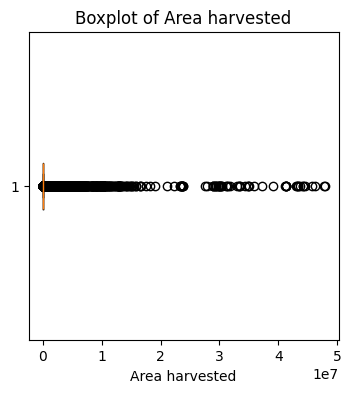

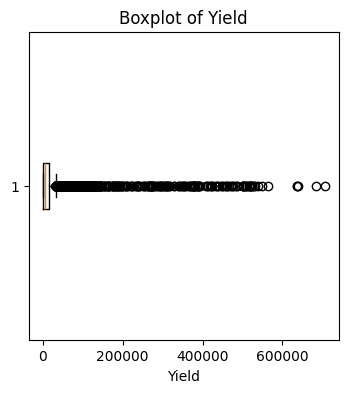

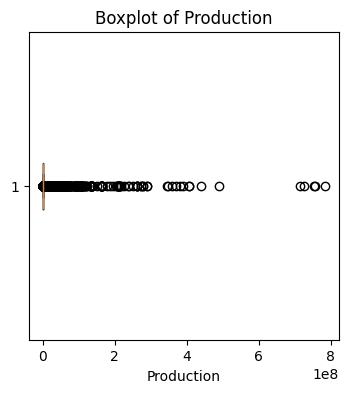

In [5]:
import matplotlib.pyplot as plt

# Define the columns to visualize
columns_to_check = ['Area harvested', 'Yield', 'Production']

# Create boxplots for each feature
for col in columns_to_check:
    plt.figure(figsize=(4, 4))
    plt.boxplot(final_cleaned_data[col], vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()


In [6]:
# Import necessary libraries
import pandas as pd
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns

# If not loaded yet, load your cleaned data
# final_cleaned_data = pd.read_csv('final_cleaned_crop_data.csv')

# Function to apply winsorization (1% on both sides)
def winsorize_column(series, limits=(0.01, 0.01)):
    return winsorize(series, limits=limits)

# Apply winsorization to key numerical columns
final_cleaned_data['Area harvested'] = winsorize_column(final_cleaned_data['Area harvested'])
final_cleaned_data['Yield'] = winsorize_column(final_cleaned_data['Yield'])
final_cleaned_data['Production'] = winsorize_column(final_cleaned_data['Production'])

print(" Winsorization (1%) applied on Area harvested, Yield, and Production columns in 'final_cleaned_data'.")


 Winsorization (1%) applied on Area harvested, Yield, and Production columns in 'final_cleaned_data'.


In [7]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


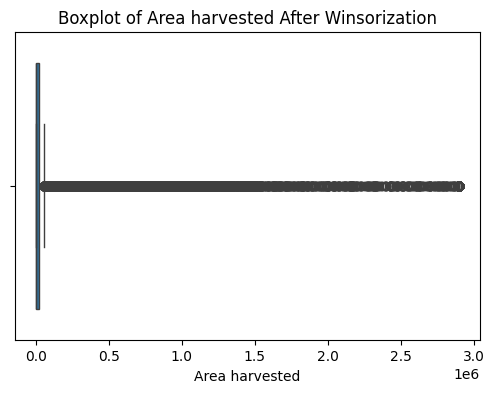

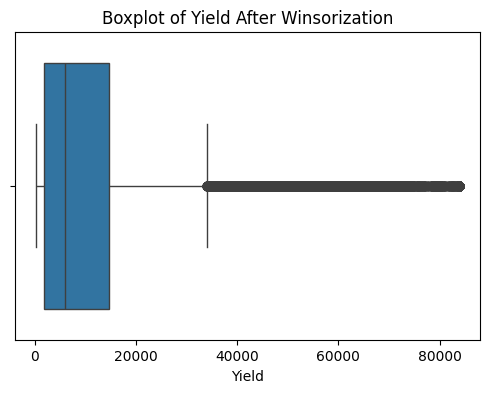

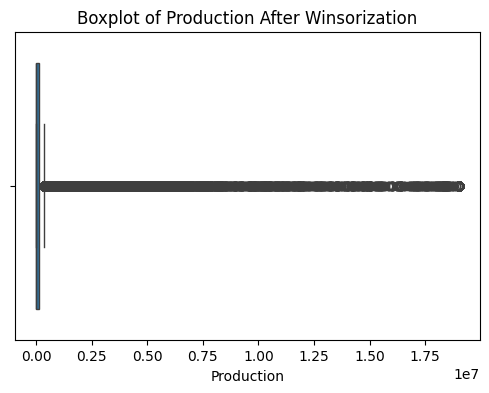

In [8]:
# Boxplots after winsorization
import matplotlib.pyplot as plt
import seaborn as sns

for col in ['Area harvested', 'Yield', 'Production']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=final_cleaned_data[col])
    plt.title(f'Boxplot of {col} After Winsorization')
    plt.xlabel(col)
    plt.show()


In [9]:
!pip install scikit-learn

from sklearn.preprocessing import LabelEncoder

# Create encoder objects
le_item = LabelEncoder()
le_area = LabelEncoder()

# Apply encoding
final_cleaned_data['Item_encoded'] = le_item.fit_transform(final_cleaned_data['Item'])
final_cleaned_data['Area_encoded'] = le_area.fit_transform(final_cleaned_data['Area'])

# Check the first few rows
final_cleaned_data[['Item', 'Item_encoded', 'Area', 'Area_encoded']].head()



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


,Item,Item_encoded,Area,Area_encoded
0,"Almonds, in shell",2,Afghanistan,0
1,"Almonds, in shell",2,Afghanistan,0
2,"Almonds, in shell",2,Afghanistan,0
3,"Almonds, in shell",2,Afghanistan,0
4,"Almonds, in shell",2,Afghanistan,0


In [10]:
# Define features (X) and target (y)
X = final_cleaned_data[['Area harvested', 'Yield', 'Year', 'Item_encoded', 'Area_encoded']]
y = final_cleaned_data['Production']

In [11]:
from sklearn.model_selection import train_test_split

# 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')


Train shape: (38347, 5), Test shape: (9587, 5)


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize and fit the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


Linear Regression Evaluation:
RMSE: 1625916.14
MAE: 604572.94
R² Score: 0.5795


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor Evaluation:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")


Random Forest Regressor Evaluation:
RMSE: 195243.63
MAE: 21485.57
R² Score: 0.9939


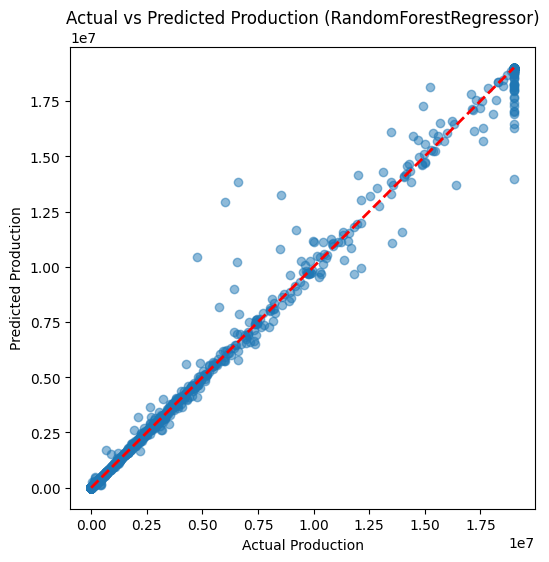

In [14]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.title('Actual vs Predicted Production (RandomForestRegressor)')
plt.show()


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined from your cleaned data:
# X = your features (with encoded Item and Area)
# y = your target 'Production'

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model again
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

print(" RandomForest model re-trained successfully!")



 RandomForest model re-trained successfully!


In [17]:
# 1. Import necessary libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pickle

# 2. Make sure your cleaned data is loaded:
# Assuming your final cleaned data is in 'final_cleaned_data.csv'
import pandas as pd
final_cleaned_data = pd.read_csv('final_cleaned_crop_data.csv')

# 3. Recreate the encoders for 'Item' and 'Area'
item_encoder = LabelEncoder()
area_encoder = LabelEncoder()

# Fit encoders on your data
final_cleaned_data['Item_encoded'] = item_encoder.fit_transform(final_cleaned_data['Item'])
final_cleaned_data['Area_encoded'] = area_encoder.fit_transform(final_cleaned_data['Area'])

# 4. Define your features and target
X = final_cleaned_data[['Item_encoded', 'Area_encoded', 'Year', 'Area harvested', 'Yield']]
y = final_cleaned_data['Production']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Define and train the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print(" Model trained and encoders created successfully!")

# 7. Save the model and encoders
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('item_encoder.pkl', 'wb') as f:
    pickle.dump(item_encoder, f)

with open('area_encoder.pkl', 'wb') as f:
    pickle.dump(area_encoder, f)

print(" Model and encoders saved successfully!")



 Model trained and encoders created successfully!
 Model and encoders saved successfully!


In [19]:
import pickle
import pandas as pd

# Step 1: Load the saved model and encoders
with open('random_forest_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('item_encoder.pkl', 'rb') as f:
    loaded_item_encoder = pickle.load(f)

with open('area_encoder.pkl', 'rb') as f:
    loaded_area_encoder = pickle.load(f)

print(" Model and encoders loaded successfully!")

# Step 2: Example test input (you can change these values to test other scenarios)
test_item = 'Almonds, in shell'        # Crop name
test_area = 'Afghanistan'              # Region name
test_year = 2020                       # Year
test_area_harvested = 25000            # Area harvested (hectares)
test_yield = 1500                      # Yield (kg/ha)

# Step 3: Encode the categorical inputs using loaded encoders
encoded_item = loaded_item_encoder.transform([test_item])[0]
encoded_area = loaded_area_encoder.transform([test_area])[0]

# Step 4: Prepare the input DataFrame (must match training feature names and order!)
test_input = pd.DataFrame({
    'Item_encoded': [encoded_item],
    'Area_encoded': [encoded_area],
    'Year': [test_year],
    'Area harvested': [test_area_harvested],
    'Yield': [test_yield]
})

# Step 5: Make the prediction
predicted_production = loaded_model.predict(test_input)[0]

print(f" Predicted Production for {test_item} in {test_area} ({test_year}): {predicted_production:.2f} tons")


 Model and encoders loaded successfully!
 Predicted Production for Almonds, in shell in Afghanistan (2020): 38102.24 tons
